# ServerModel Encoding and Decoding

The `CartpoleServer` is of ServerModel type. It represents a [complex datatype](https://en.wikipedia.org/wiki/Composite_data_type). This notebook tests approaches for encoding and decoding the datatype.

## Motivation

A complex datatype mixes the attributes of different types. The example shows a simplified version of the ServerModel.
```
typedef struct {
    float position;
    float velocity;
    string direction;
} ServerModel;
```

The service program operates on one or more ServerModel instances. It transform them into a new ServerModel instance. Encoding the ServerModel datatype shall provide the data in an appropriate input format for the service program. 

## Problem

Well-known approaches from DeepLearning examples use images or texts. This data is encoded as vectors with the same datatype for each component in the vector. However, our complex datatype has attributes of different type.

**Problem formulation:** Find a numerical encoding in vector form of a complex data. 

## Solution Approach

We encode the our data using heterogenous distances measures. 

## Install requirements

In [1]:
%%bash
# define project environment
PROJECT_DIR="/DRL4REST"
OPENAPI_SERVER_DIR="$PROJECT_DIR/openapi/cartpole/python-flask"

# install requirements
cd "$OPENAPI_SERVER_DIR" || exit
pip install -r requirements.txt || exit
pip install -r test-requirements.txt || exit

# install other requirements
pip install Werkzeug==0.16.1 || exit

Ignoring connexion: markers 'python_version == "3.5"' don't match your environment
Ignoring connexion: markers 'python_version == "3.4"' don't match your environment
Ignoring connexion: markers 'python_version <= "2.7"' don't match your environment
  Created wheel for flask-testing: filename=Flask_Testing-0.6.1-py3-none-any.whl size=7639 sha256=4ce984a31487bf99fab4c2c2ef4329ad2d8b00320d2b7118793605c7eb43020c
  Stored in directory: /home/jovyan/.cache/pip/wheels/d3/a7/7f/effdb220813fd331ca8d1961b4fd629fa6dcd54c9cdc83eaeb
Successfully built flask-testing
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 1.0.1
    Uninstalling Werkzeug-1.0.1:
      Successfully uninstalled Werkzeug-1.0.1


You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


## Other Installs

[Distython](https://github.com/KacperKubara/distython) is a ready-to-use heterogeneous distance metrics which are compatible with Scikit-Learn.

In [21]:
%%bash
pip install distython

You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


## Import

In [2]:
# set path to import code generated by OpenAPI
import sys
sys.path.append("/DRL4REST/openapi/cartpole/python-flask")
sys.path.append("/DRL4REST/src")

In [3]:
from flask import json

from openapi_server.models.cart import Cart  # noqa: E501
from openapi_server.models.pole import Pole  # noqa: E501
from openapi_server.models.direction import Direction  # noqa: E501

from cartpole.gprest.server_model import CartpoleServer

In [4]:
# printing
from pprint import pprint

## Create n ServerModel Instances

Create n instances of `CartpoleServer`.

In [708]:
cps = CartpoleServer
cps.create_cart()
cps.create_pole()
#cps.create_direction() # there is no create method for direction

In [709]:
# read the cart
org_cart = cps.read_cart()
pprint(org_cart)

{'direction': 'right',
 'position': 0.8192191489422173,
 'velocity': 0.8242012817761788}


In [710]:
# Creates n ServerModel instances with random data
cps.n_instances(n=10)
pprint(cps._instances[1]._cart)

{'direction': 'right',
 'position': 0.25236073903507905,
 'velocity': 0.8473655913269325}


## Compute HEOM Distance Matrix

For each pair of ServerModel instances we compute the HEOM (Heterogeneous Euclidean-Overlap Metric) distance.

1. Creata a pandas dataframe from the ServerModel instances
1. Compute the HEOM distance matrix of pairwise ServerModel instances

In [715]:
import numpy as np
import pandas as pd
from distython import HEOM

In [716]:
# For each ServerModel we add a row in a dataframe 
# The row contains the ServerModel attributes' values as columns
#
# Assumptions
# 1. There are no duplicate attribute names
# 2. If an attribute is NULL / None in one instance, it is NULL / None in all instances
sm_vars = cps.states_varnames()
df_sm = pd.DataFrame() # table containing ServerModel attribute values

for inst in cps._instances:
    sm_vars_data = {}
    for var in cls_vars:
        sm_vars = vars(inst)[var] 
        if sm_vars is None:
            continue
        dict_sm_vars = sm_vars.to_dict()
        sm_vars_data.update(dict_sm_vars)
    df_sm = df_sm.append(other=sm_vars_data, ignore_index=True)
# drop rows with nan    
df_sm = df_sm.dropna()

In [713]:
df_sm.to_pickle('/tmp/df_sm.pkl')

In [717]:
# list of indices for categorical vars
# Assumption: categorical vars are non-numerical vars
col_names = df_sm.columns
numeric_col_names = df_sm._get_numeric_data().columns
cat_col_names = list(set(col_names) - set(numeric_col_names))
cat_col_idx = [df_sm.columns.get_loc(c) for c in cat_col_names if c in df_sm]

In [718]:
df_sm.head()

,angle,direction,position,velocity
0,0.324968,left,0.374893,0.097642
1,2.972704,right,0.252361,0.326815
2,1.798959,left,0.523011,0.480728
3,0.530906,right,0.338869,0.111247
4,1.590595,right,0.745985,0.262556


In [719]:
# we need to convert strings to integers
for i in cat_col_idx:
    df_sm['code'] = df_sm.iloc[:,i].astype('category').cat.codes
    df_sm.iloc[:,i] = df_sm['code'] + 1
df_sm = df_sm.iloc[:,0:-1]
df_sm
#df_sm['code'] = range(10)
#df_sm['direction'] = df_sm['code']
#df_sm = df_sm.iloc[:,0:-1]

,angle,direction,position,velocity
0,0.324968,1,0.374893,0.097642
1,2.972704,2,0.252361,0.326815
2,1.798959,1,0.523011,0.480728
3,0.530906,2,0.338869,0.111247
4,1.590595,2,0.745985,0.262556
5,0.504898,1,0.376701,0.411187
6,1.291010,1,0.362096,0.178116
7,2.113575,1,0.574167,0.029561
8,1.776005,1,0.332852,0.972771
9,2.268046,1,0.304529,0.792273


In [720]:
# Declare the HEOM 
heom_metric = HEOM(df_sm.to_numpy(), cat_col_idx)
# compute the HEOM matrix
heom_matrix = pd.DataFrame()
for idx1, row1 in df_sm.iterrows():
    for idx2, row2 in df_sm.iterrows():
        d = heom_metric.heom(row1, row2)
        heom_matrix.loc[idx1, idx2] = d

In [721]:
heom_matrix

,0,1,2,3,4,5,6,7,8,9
0,0.000000,2.120653,0.564909,1.011584,1.824215,0.115137,0.141071,0.624511,1.168440,1.101240
1,2.120653,0.000000,1.523768,0.933439,1.277122,1.940157,1.477682,1.629612,1.699885,1.325523
2,0.564909,1.523768,0.000000,1.521974,1.263737,0.332158,0.246004,0.253660,0.420616,0.336389
3,1.011584,0.933439,1.521974,0.000000,0.866125,1.107094,1.089653,1.592017,2.055577,1.956615
4,1.824215,1.277122,1.263737,0.866125,0.000000,1.752635,1.625626,1.221191,2.272344,2.180672
5,0.115137,1.940157,0.332158,1.107094,1.752635,0.000000,0.150085,0.692868,0.592858,0.628051
6,0.141071,1.477682,0.246004,1.089653,1.625626,0.150085,0.000000,0.305894,0.746870,0.573744
7,0.624511,1.629612,0.253660,1.592017,1.221191,0.692868,0.305894,0.000000,1.255243,0.955672
8,1.168440,1.699885,0.420616,2.055577,2.272344,0.592858,0.746870,1.255243,0.000000,0.074448
9,1.101240,1.325523,0.336389,1.956615,2.180672,0.628051,0.573744,0.955672,0.074448,0.000000


In [714]:
np.sqrt(0.665190)

0.8155918096695184

In [358]:
r = df_sm.iloc[:,[2,3]].max(axis=0,numeric_only=True).to_numpy()

In [379]:
s1 = df_sm.iloc[1, [1,2]]
s2 = df_sm.iloc[2, [1,2]]
s1.eq(s2).astype(int).to_numpy()

array([1, 0])

In [726]:
s1 = df_sm.iloc[1, [2,3]]
s2 = df_sm.iloc[2, [2,3]]
sdiff = s1.to_numpy() - s2.to_numpy()
type(sdiff)

numpy.ndarray

In [390]:
np.abs(s1.to_numpy() - s2.to_numpy())

array([0.04928641, 0.39216389])

In [411]:
s1[[0,1]]

position    0.236672
velocity    0.423146
Name: 1, dtype: float64

In [415]:
s1[[0,1]].to_numpy()

array([0.23667247, 0.42314583])

In [464]:
row = df_sm.iloc[[1], [0, 2, 3]]
row.to_numpy()

array([[2.78152366, 0.23667247, 0.42314583]])

In [465]:
row.ndim

2

In [467]:
row = df_sm.iloc[1, [0, 2, 3]]
row.to_numpy()

array([2.78152366, 0.23667247, 0.42314583])

In [468]:
row.ndim

1

In [723]:
row = df_sm.iloc[[1], [0, 2, 3]]
row.ndim
#row


2

In [481]:
for idx1, row1 in df_sm.iterrows():
    pprint(type(row1))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [494]:
assert row1.ndim == 0

AssertionError: 

In [505]:
assert len([0,2,3]) + len([1]) == len(df_sm.columns)

In [511]:
df_sm.shape[1]

4

In [523]:
s1.isna().values

array([False, False])

In [552]:
list(s1.index.values)

['position', 'velocity']

In [553]:
[df_sm.columns.get_loc(c) for c in list(s1.index.values) if c in df_sm]

[2, 3]

In [534]:
s1

position    0.236672
velocity    0.423146
Name: 1, dtype: float64

In [591]:
s1_nan = s1.isnull().append(s1.isna())


position    False
velocity    False
position    False
velocity    False
Name: 1, dtype: bool

In [589]:
s1_false_null = [i for i,v in s1_nan.iteritems() if v is False]

AttributeError: 'numpy.ndarray' object has no attribute 'iteritems'

In [586]:
nan_s1_idx = [df_sm.columns.get_loc(c) for c in s1_false_null if c in df_sm]
nan_s1_idx

[2, 3, 2, 3]

In [601]:
nan_idx=list(set(nan_s1_idx) - set([2,3]))

In [604]:
s1[nan_idx].to_numpy()

array([], dtype=float64)

In [732]:
ss=s2.to_numpy()
type(ss)

numpy.ndarray

In [612]:
n = np.maximum(len(s1.to_numpy()), len(s2.to_numpy()))
np.ones(2)

array([1., 1.])

In [617]:
s1 = df_sm.iloc[1, :]
s1

angle        2.781524
direction    2.000000
position     0.236672
velocity     0.423146
Name: 1, dtype: float64

In [729]:
s1[[1,2]].to_numpy()

IndexError: index 2 is out of bounds for axis 0 with size 2

In [622]:
s1.to_numpy()[[1,2]]

array([2.        , 0.23667247])

In [626]:
sm_vars = cps.states_varnames()
df = pd.DataFrame() # table containing ServerModel attribute values

for inst in cps._instances:
    sm_vars_data = {}
    for var in cls_vars:
        sm_vars = vars(inst)[var] 
        if sm_vars is None:
            continue
        dict_sm_vars = sm_vars.to_dict()
        sm_vars_data.update(dict_sm_vars)
    df = df.append(other=sm_vars_data, ignore_index=True)
# drop rows with nan    
df = df.dropna()

In [659]:
s1 = df.iloc[1,:]
s2 = df.iloc[1,:]
s1 = s1.to_numpy()
s2 = s2.to_numpy()

In [660]:
idx = [0, 2,3]
#s1[idx] / [0.5, 0.5]
s1[idx] = s1[idx] / [0.5, 0.5, 0.5]
s1

array([5.563047320918991, 'right', 0.4733449395646996, 0.8462916587597127],
      dtype=object)

In [661]:
div = [0.5, 0.5, 0.5]

def f(x, div):
    return x / div

s2[idx] = f(s2[idx], div)
s2

array([5.563047320918991, 'right', 0.4733449395646996, 0.8462916587597127],
      dtype=object)

In [703]:
np.not_equal(s1, s2).astype(int)

array([0, 0, 0, 0])

In [679]:
assert 0 <= -1 < 10

AssertionError: 

In [690]:
np.zeros(s1.shape)

array([0., 0., 0., 0.])

In [702]:
m=np.zeros(5)
assert m != 0

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [706]:
type(df.loc[1])

pandas.core.series.Series

In [707]:
len(df.columns)

4

In [757]:
import numpy as np

N = 100
b = np.random.rand(N, N)
b_symm = (b + b.T)/2
b

array([[0.60357727, 0.73556976, 0.97280779, ..., 0.39705022, 0.69385708,
        0.87651232],
       [0.89871853, 0.82011415, 0.72529473, ..., 0.25805586, 0.04605194,
        0.17543126],
       [0.49627429, 0.2099724 , 0.87679778, ..., 0.82655057, 0.53494767,
        0.59839913],
       ...,
       [0.47926156, 0.35778802, 0.33196225, ..., 0.4437238 , 0.56607707,
        0.07702351],
       [0.77387206, 0.0465094 , 0.09945309, ..., 0.84769014, 0.20849209,
        0.2169003 ],
       [0.25677655, 0.43147452, 0.81696281, ..., 0.86971442, 0.85865431,
        0.94529609]])

In [782]:
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh

affinity_matrix = b
lpn = laplacian(affinity_matrix, normed=True)
w, v = eigsh(lpn, k=2, which='SM')

In [783]:
pd.DataFrame(v).head()

,0,1
0,0.109799,-0.009345
1,0.096627,-0.076538
2,0.099714,0.205922
3,0.102584,-0.048140
4,0.098126,0.039011


In [784]:
pd.DataFrame(v).shape

(100, 2)

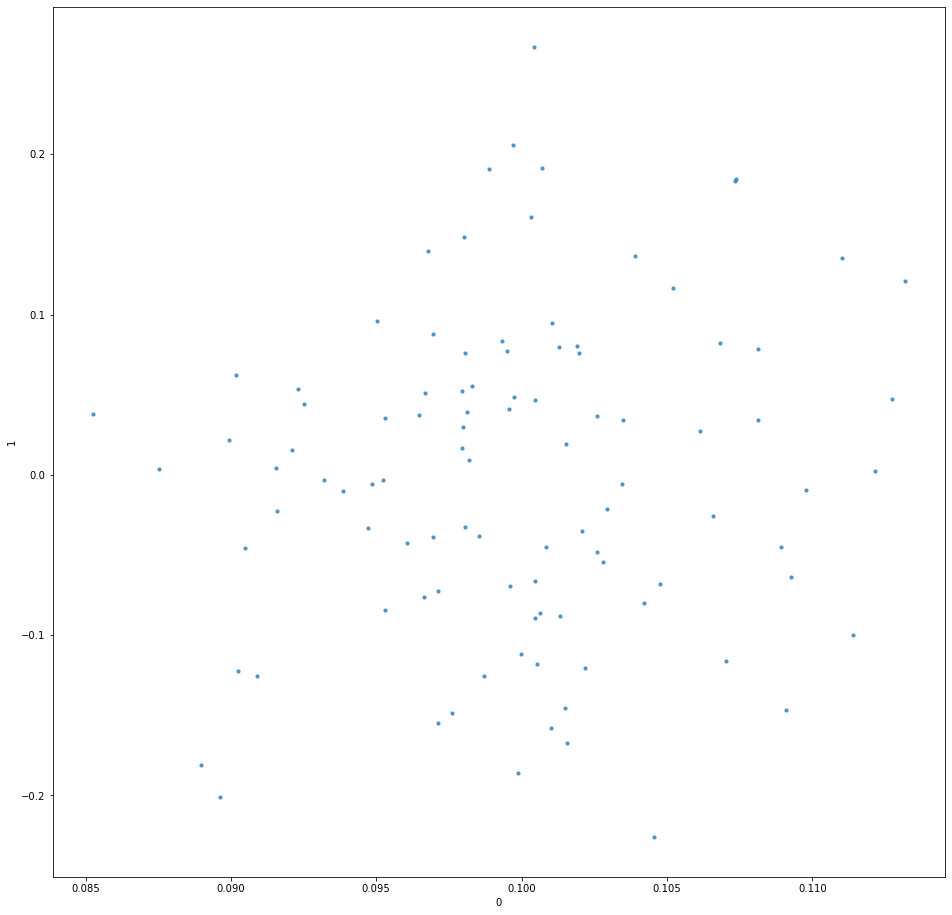

In [785]:
pd.DataFrame(v).plot(
    kind='scatter',
    x=0,
    y=1,
    figsize=(16, 16),
    s=10,
    alpha=0.7
)